# Strava training analysis

In [50]:
# Enable local module import
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('./src')) # or the path to your source code
sys.path.insert(0, module_path)

# Import all required modules
from dotenv import load_dotenv
import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from stravalib.client import Client

# Local modules
import utility

# Create stravalib client object
client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Request authentication code

1. The next step is a one-time authentication, i.e. this only needs to be done once initially. The code below generates a URL an athlete of interest can paste into the browser to autheticate your app to retrieve the athlete's training data. The scope is really important here, so that you get access to all relevant data (*read_all*).

In [51]:
load_dotenv()
STRAVA_CLIENT_ID = os.environ.get("STRAVA_CLIENT_ID")
print("Client ID '{}' read from env file".format(STRAVA_CLIENT_ID))

#url = client.authorization_url(
#    client_id=STRAVA_CLIENT_ID,
#    redirect_uri="http://127.0.0.1:5000/authorization",
#    scope=["read_all", "profile:read_all", "activity:read_all"],
#)
#url

Client ID '105718' read from env file


2. Paste the above URL into your browser, where you will be redirected to Strava's authentication page. This URL contains the one-time code, which you save as 'STRAVA_ONE_TIME_CODE' in the .env file. It will be used in the next step to obtain the access token (stored in a binary file `access_token.pickle`)

In [52]:
STRAVA_CLIENT_SECRET = os.environ.get("STRAVA_CLIENT_SECRET")
STRAVA_ONE_TIME_CODE = os.environ.get("STRAVA_ONE_TIME_CODE")
print("Client secret and one time code read from env file")

#access_token = client.exchange_code_for_token(
#    client_id=STRAVA_CLIENT_ID,
#    client_secret=STRAVA_CLIENT_SECRET,
#    code=STRAVA_ONE_TIME_CODE,
#)

#with open("../access_token.pickle", "wb") as f:
#    pickle.dump(access_token, f)

Client secret and one time code read from env file


In [53]:
# Read access token from file
# Check if token is still valid, otherwise refresh
# (short-lived token, expires after 6 hours)
try:
    access_token = utility.checkAndRefreshToken(
        client, 
        utility.readAccessTokenFromFile(), 
        STRAVA_CLIENT_ID, 
        STRAVA_CLIENT_SECRET)
except ValueError:
    print("Refreshing token failed!")

## Data analysis

Get athlete data from Strava API

In [54]:
# Retrieve data from Strava API
athlete = utility.GetAthlete(client)
activities = utility.GetActivities(client)

  return v.num



In [55]:
# Latest activity
utility.PrintLatestActivity(client, activities)

,Latest Activity
name,Mittagslauf
type,Run
date,02.05.2023 10:04:28 Uhr
duration,30.6 min
mileage,5.2488 km
avgHR,137 bpm
kcal,300


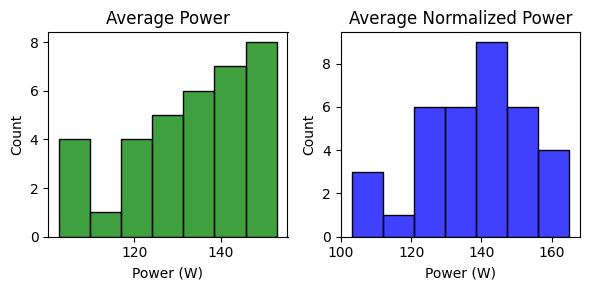

In [57]:
avg_watts = []
avg_watts_norm = []
for act in activities:
    if act[1]['average_watts'] is not None:
        avg_watts.append(act[1]['average_watts'])
        avg_watts_norm.append(act[1]['weighted_average_watts'])

avg_watts_norm_df = pd.DataFrame(data=avg_watts_norm, columns=["Power (W)"])
avg_watts_df = pd.DataFrame(data=avg_watts, columns=["Power (W)"])

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
sns.histplot(data=avg_watts_df,
                 x="Power (W)",
                 ax=axs[0],
                 color='green')
axs[0].set_title("Average Power")
sns.histplot(data=avg_watts_norm_df,
                 x="Power (W)",
                 ax=axs[1],
                 color='blue')
axs[1].set_title("Average Normalized Power")

plt.tight_layout()
plt.show()


  return v.num



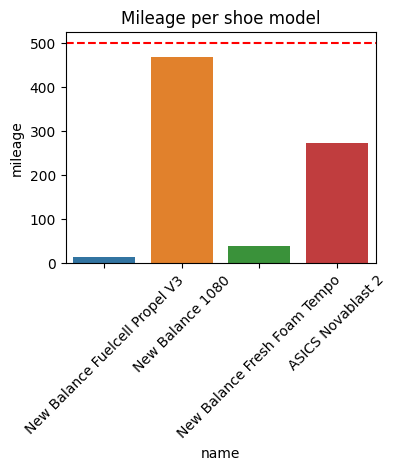

In [58]:
shoe_mileage = utility.getMileagePerShoe(athlete)

fig, axs = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=shoe_mileage, x='name', y='mileage')
plt.xticks(rotation=45)
plt.axhline(y=500, color='r', linestyle='--', linewidth=1.5)
axs.set_title("Mileage per shoe model")
plt.show()

Now we define the columns that we're interested in and iterate through the activities:

In [59]:
df = utility.processActivityData(activities)

df.head(3)

,id,name,start_date_local,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,...,max_heartrate,start_latitude,start_longitude,average_watts,max_watts,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr
0,8995455172,Mittagslauf,2023-05-02 12:04:28,Run,5248.8,30.566667,30.633333,16.0,75.3,61.0,...,155.0,,,,,5.2488,Tuesday,5,0.500000,0.500000
1,8981577775,Lauf am Morgen,2023-04-30 08:31:01,Run,4214.5,25.033333,25.033333,15.9,75.3,56.6,...,154.0,,,,,4.2145,Sunday,4,0.416667,0.416667
2,8966661961,Schwimmen am Nachmittag,2023-04-27 15:39:43,Swim,1200.0,32.533333,32.533333,0.0,,,...,130.0,,,,,1.2000,Thursday,4,0.533333,0.533333


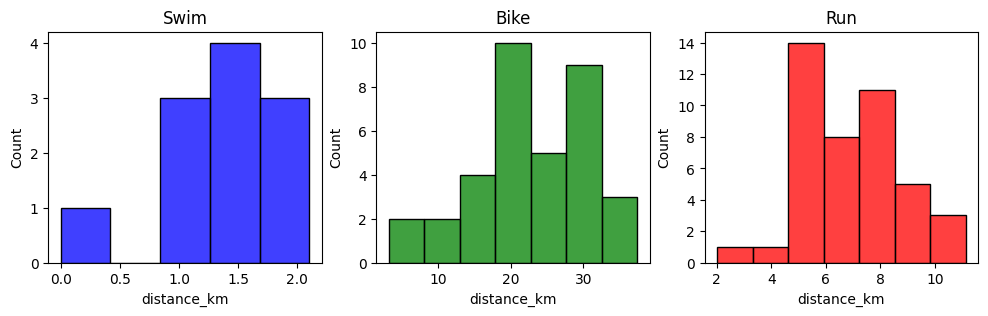

In [60]:
activity_types = ['Swim', 'Bike', 'Run']
activity_colors = ['b', 'g', 'r']

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for i in range(len(activity_types)):
    sns.histplot(data=df[df['type'] == activity_types[i]],
                 x="distance_km",
                 ax=axs[i],
                 color=activity_colors[i])
    axs[i].set_title(activity_types[i])
plt.show()

In [70]:
streams = list()

# Streams types are: time, latlng, distance, altitude, velocity_smooth,
# heartrate, cadence, watts, temp, moving, grade_smooth
# https://pythonhosted.org/stravalib/api.html?
# highlight=get_activity_streams#stravalib.client.Client.get_activity_streams

types = ['time', 'heartrate', 'velocity_smooth', 'cadence', 'watts']

for act in activities:
    if act[1]['type'] == "Ride":
        streams.append(utility.ParseActivityStream(client, act, types))

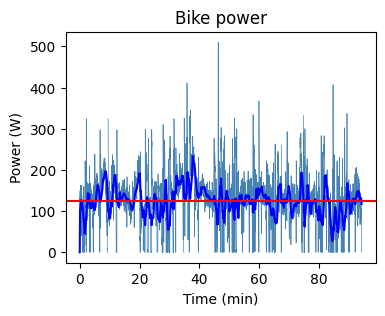

In [99]:
bike_watts_total_df, cadence_total_df = utility.getOverallWattsAndCadence(streams)

# Plot the latest ride here
data_for_plot = streams[0]
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
time_axis = np.arange(len(data_for_plot)) / 60.0
plt.plot(time_axis, data_for_plot['watts'],color='steelblue',linewidth=0.5)
plt.plot(time_axis, data_for_plot['watts_moving_avg'],color='blue',linewidth=1.5)
axs.set_title("Bike power")
plt.xlabel("Time (min)")
plt.ylabel("Power (W)")
plt.axhline(np.mean(data_for_plot['watts']), color='red')
plt.show()

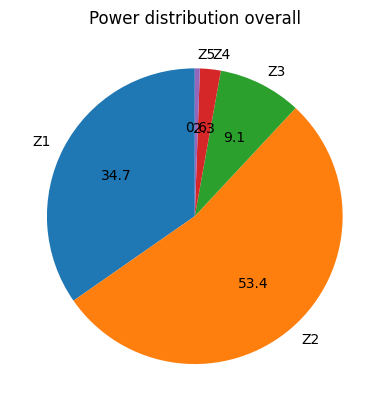

In [97]:
bike_watts_total_df['bins'] = pd.cut(bike_watts_total_df['power'],
                          bins=utility.setPowerZones(200),
                          labels=["Z1", "Z2", "Z3", "Z4", "Z5"])
df = bike_watts_total_df.groupby(['bins']).size()

df.plot.pie(autopct='%1.1f', startangle=90)
plt.title('Power distribution overall')
plt.show()

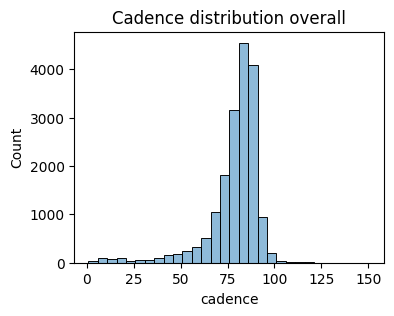

In [94]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
# Ignore zero values from coasting on outdoor bike ride
axs = sns.histplot(data=cadence_total_df, x='cadence', binwidth=5, alpha=0.5, binrange=[1,150])
plt.title('Cadence distribution overall')
plt.show()

### TODO:

- Run: time in heartrate zones (this week, 30 days, overall)
- Bike: time in power zones (this week, 30 days, overall)
- Run mileage per week